In [10]:
import numpy as np
from numpy.fft import fft, ifft
from scipy.io import wavfile
import matplotlib.pyplot as plt
import sounddevice as sd
from IPython.display import Audio
from scipy import signal
from helpers import *

figsize=(10,5)
fs=44100

# Pitch control

Let's start by implementing Pitch control, that straight-forwardly consists in resampling the signal while keeping the lecture sample rate the same.

In [208]:
def pitch_control(x, r):
    """Simple pitch control.
    
    x: input signal
    r: ratio of the time and pitch modification
    """
    return signal.resample(x, int(x.size/r))

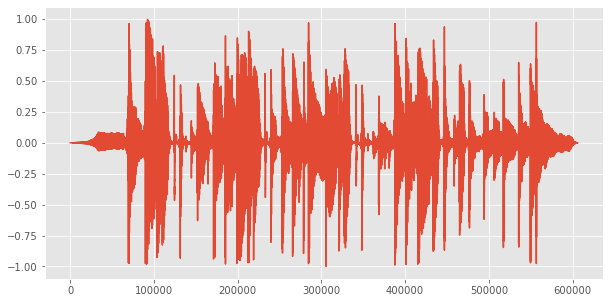

In [155]:
fs, data = wavfile.read('samples/guitar.wav')
guitar_sample = np.array(data, dtype=np.float32)
guitar_sample /= np.max(np.abs(guitar_sample) )
plt.figure(figsize=figsize)
plt.plot(guitar_sample)
Audio("samples/guitar.wav", autoplay=False)

In [156]:
guitar_pitched = pitch_control(guitar_sample, 0.8)

# Write to disk
wavfile.write('samples/guitar_pitched.wav', fs, (0x7FFF * guitar_pitched).astype(np.int16))
Audio("samples/guitar_pitched.wav", autoplay=False)

# Pitch scaling

Let's now implement pitch scaling while keeping the duration the same. We use a phase vocoder implementation, which means that for each chunk of the STFT, the phase information will be used to smooth out the intersection between the chuncks. We first cut the signal into chuncks, then change the pitch of each chunk independetly using the pitch control, and then adapt the phase of the chunks to match the previous chunk's. The new chunks have a different duration than the original ones, due to the pitch control property, but we still add them at the same rate that we cut them at first, to preserve global duration.

In [237]:
def PS_pitch(x, r, w, h):
    """Pitch sclaing using a phase vocoder.
    Inspired from an implementation by Zulko: http://zulko.github.io
    
    x: input signal
    r: pitch modification ratio
    w: window size
    h: step between 2 windows' starts
    """

    phase  = np.zeros(int(w/r))
    hanning_window = np.hanning(w)
    hanning_pitch = np.hanning(int(w/r))
    result = np.zeros(x.size + w)

    for i in np.arange(0, int(x.size-(w+h)), h):

        # Get 2 chunks (first for phase, second will be edited)
        a1 = x[i: i + w]
        a2 = x[i + h: i + w + h]

        # Pitch shift the chunks
        a1_pitch = pitch_control(a1, r)
        a2_pitch = pitch_control(a2, r)
        
        s1 = fft(hanning_pitch * a1_pitch)
        s2 = fft(hanning_pitch * a2_pitch)
        
        # Phase synchronization
        phase = (phase + np.angle(s2/s1)) % 2*np.pi
        s2_rephased = np.abs(s2)*np.exp(1j*phase)
        a2_rephased = np.real(ifft(s2_rephased))

        # Put the chucks together
        result[i : int(i + w/r)] += hanning_pitch*a2_rephased

    return result / np.max(np.abs(result) )

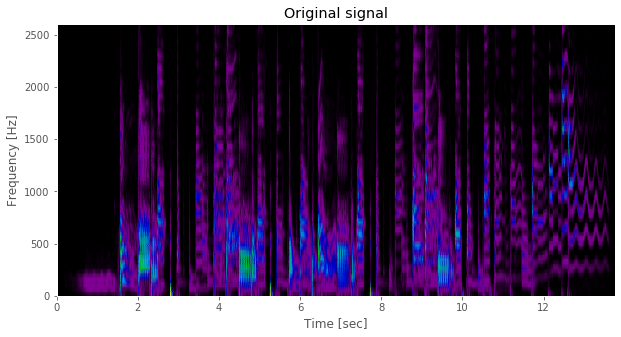

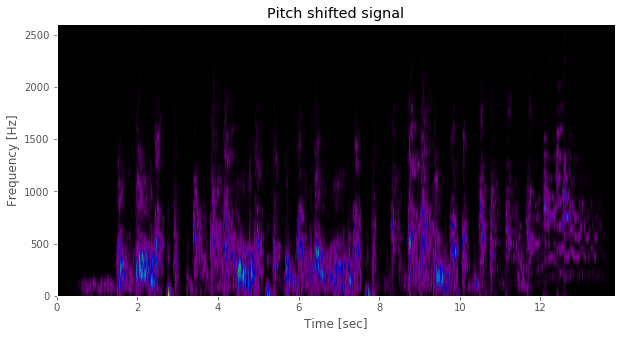

In [247]:
guitar_pitched = PS_pitch(guitar_sample, 0.7, 4200, 1900)

# Plot
f, t, Zxx = signal.stft(guitar_sample, fs, nperseg=1000)
plt.figure(figsize=figsize)
plt.pcolormesh(t, f[:60], np.abs(Zxx[:60,:]), cmap='nipy_spectral', shading='gouraud')
plt.title("Original signal")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

f, t, Zxx = signal.stft(guitar_pitched, fs, nperseg=1000)
plt.figure(figsize=figsize)
plt.pcolormesh(t, f[:60], np.abs(Zxx[:60,:]), cmap='nipy_spectral', shading='gouraud')
plt.title("Pitch shifted signal")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

# Write to disk
wavfile.write('samples/guitar_pitched.wav', fs, (0x7FFF * guitar_pitched).astype(np.int16))
Audio("samples/guitar_pitched.wav", autoplay=False)

# Time stretching

We can finally move to time streching effect, also implemented using a Phase Vocoder. This time, each chunck is not pitch shifted, but simply phase corrected to match the previous chunk's phase, and then put back together with a different overlapping amount than when cutting the chunks. Larger overlaps make the final duration shorter!

In [206]:
def PS_stretch(x, r, w, h):
    """Time strech using a phase vocoder
    Inspired from an implementation by Zulko: http://zulko.github.io
    
    x: input signal
    r: time modification ratio
    w: window size
    h: step between 2 windows' starts
    """

    phase  = np.zeros(w)
    hanning_window = np.hanning(w)
    result = np.zeros( int(x.size /r + w))

    for i in np.arange(0, x.size-(w+h), int(h*r)):

        # Get 2 chunks (first for phase, second will be edited)
        a1 = x[i: i + w]
        a2 = x[i + h: i + w + h]

        # Phase synchronization
        s1 =  fft(hanning_window * a1)
        s2 =  fft(hanning_window * a2)
        phase = (phase + np.angle(s2/s1)) % 2*np.pi
        a2_rephased = np.real(ifft(np.abs(s2)*np.exp(1j*phase)))

        # Put the chunks together
        i2 = int(i/r)
        result[i2 : i2 + w] += hanning_window*a2_rephased

    return result / np.max(np.abs(result) )

In [245]:
guitar_streched = PS_stretch(guitar_sample, 0.8, 4100, 1900)

# Write to disk
wavfile.write('samples/guitar_streched.wav', fs, (0x7FFF * guitar_streched).astype(np.int16))
Audio("samples/guitar_streched.wav", autoplay=False)

A time strech is also achievable by combining a pitch-scale and a pitch control in series!

In [241]:
guitar_streched2 = pitch_control(PS_pitch(guitar_sample, 1/0.8, 4200, 1700), 0.8)

# Write to disk
wavfile.write('samples/guitar_streched2.wav', fs, (0x7FFF * guitar_streched2).astype(np.int16))
Audio("samples/guitar_streched2.wav", autoplay=False)